# Equipe 16: Angelo EAP & Valentin SAN

# Sommaire


- [Preprocessing](#Preprocessing)
- [Model](#Model)
- [Training](#Training)
- [Results](#Results)
- [Submission](#Submission)

# Setup

In [1]:
! pip install --upgrade keras-cv tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.8.2
    Uninstall

# Extraction des images

In [2]:
!tar xzf /kaggle/input/navires-2024-fait-main/ships24.tgz

In [3]:
!ls /kaggle/working

__notebook__.ipynb  ships_gray	test.npy


# Imports
Définition d'une seed pour permettre la reproductibilité des résultats.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from PIL import Image


import pathlib
import os


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers

from keras_cv.src.backend import ops 
from keras_cv.src.backend import random
import keras_cv

# Définition of the seed
SEED = 12345

# Initializing of random number generators with the seed
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Affichage d'une image

192
128


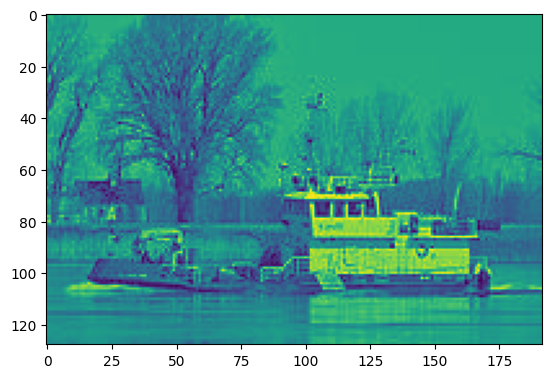

In [5]:
data_dir = '/kaggle/working/ships_gray'
data_dir = pathlib.Path(data_dir).with_suffix('')

coastguard_scaled = list(data_dir.glob('coastguard_scaled/*'))

gray_img = Image.open(str(coastguard_scaled[0]))
plt.imshow(gray_img)
img_width, img_height = gray_img.size

print(img_width)
print(img_height)


# Preprocessing

- Pour le preprocessing des images nous avons utilisé ```ImageDataGenerator``` de keras afin de pouvoir altérer aléatoirement les images et ainsi rajouter du bruit pour permettre à notre modèle de mieux apprendre.
- Nous avons notamment utilisé la rotation d'image, la distorsion, le zoom, les retournements d'images et la luminosité.
- Nous avions l'habitude de partager notre dataset en train/test (0.9/0.1), mais nous avons décidé de ne plus prendre de partie test puisque notre modèle n'overfittait pas et avons réussi à obtenir de meilleures performances en ayant plus de données d'entraînement.

In [6]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.2,1.7],
#     validation_split=0.1,
    fill_mode='nearest',
    rescale=1./255)

train = datagen.flow_from_directory(
  data_dir,
  subset="training",
  seed=SEED,
  batch_size=64,
  class_mode='categorical',
  shuffle=True,
  target_size=(128, 192),
  color_mode="grayscale")

# val = datagen.flow_from_directory(
#   data_dir,
#   subset="validation",
#   class_mode='categorical',
#   shuffle=True,
#   seed=SEED,
#   batch_size=64,
#   target_size=(128, 192),
#   color_mode="grayscale")

# class_names = train.class_names
class_names = train.class_indices
print(class_names)

Found 42204 images belonging to 10 classes.
{'coastguard_scaled': 0, 'containership_scaled': 1, 'corvette_scaled': 2, 'cruiser_scaled': 3, 'cv_scaled': 4, 'destroyer_scaled': 5, 'methanier_scaled': 6, 'smallfish_scaled': 7, 'submarine_scaled': 8, 'tug_scaled': 9}


# Affichage des images après modifications par ```ImageDataGenerator```

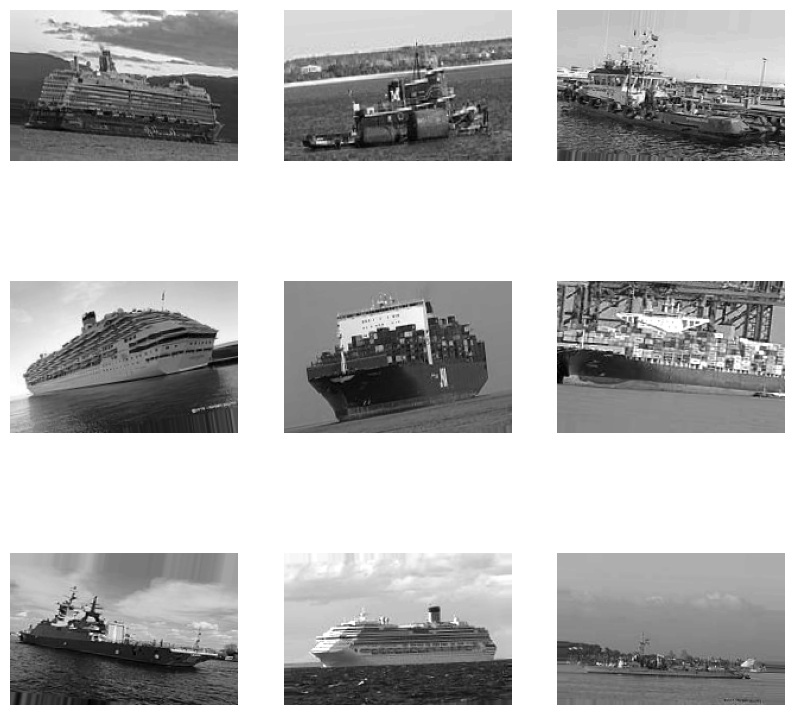

In [7]:
import matplotlib.pyplot as plt

# Retrieve a batch of images and labels
images, labels = next(train)

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i], cmap='gray')  # Display grayscale images
    plt.axis("off")
plt.show()

In [8]:
for image_batch, labels_batch in train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 128, 192, 1)
(64, 10)


# Model

Dès le début de la compétition nous nous sommes inspirés du modèle VGGNET (configuration A, voir image ci-dessous) afin d'implémenter notre propre CNN. (https://www.researchgate.net/figure/Experimental-configuration-of-convolution-layers-used-by-VggNet_fig2_355287753)

- Après avoir obtenue de bons résultats avec la fonction d'activation ```relu``` , nous avons regardé ses variantes et avons eu de meilleures résultats avec ```LeakyRelu```
- Pour le preprocessing, nous avions des couches de preprocessing directement dans le modèle mais cela prenait beaucoup de couches, sachant qu'on était limité a 30 couches. C'est pourquoi nous avons utilisé ```ImageDataGenerator``` 

- Nous avons utilisé le regularisateur L2, qui permet de pénaliser fortement, et est couramment utilisé dans des CNN.
- Nous avons initialement utilisé la couche Dropout de Keras, une technique de régularisation utilisée dans les réseaux de neurones pour prévenir le surapprentissage (overfitting). Pour cela, il désactive aléatoirement un pourcentage de neurones durant l'entrainement. Cependant, la couche Dropout classique peut être moins efficace dans les couches convolutives où les neurones sont spatialement corrélés, ce qui est notre cas. DropBlock est une variante plus structurée de Dropout, spécialement conçue pour les réseaux convolutifs. Cependant, nous avons avons décidé de légèrement changer son comportement lorsqu'il est appelé pour résoudre de nombreux problèmes liés à cette couche issue de keras_cv (https://stackoverflow.com/questions/78496946/keras-cv-dropblock2d-does-not-work-in-keras-model-without-eager-run).

![](https://media.discordapp.net/attachments/628933474794864640/1228415096355819560/image.png?ex=665c1475&is=665ac2f5&hm=1a69921d4aee6d1f7fe8c82cb51163eb61e24e3651ab8d594ba531240117faeb&format=webp&quality=lossless&)

In [9]:
from keras_cv.src.backend import ops 
from keras_cv.src.backend import random
import keras_cv
class PatchedDropBlock2D(keras_cv.layers.DropBlock2D):
    def call(self, x, training=None):
        if not training or self._rate == 0.0:
            return x

        _, height, width, _ = ops.split(ops.shape(x), 4)

        # Unnest scalar values
        height = ops.squeeze(height)
        width = ops.squeeze(width)

        dropblock_height = ops.minimum(self._dropblock_height, height)
        dropblock_width = ops.minimum(self._dropblock_width, width)

        gamma = (
            self._rate
            * ops.cast(width * height, dtype="float32")
            / ops.cast(dropblock_height * dropblock_width, dtype="float32")
            / ops.cast(
                (width - self._dropblock_width + 1)
                * (height - self._dropblock_height + 1),
                "float32",
            )
        )

        # Forces the block to be inside the feature map.
        w_i, h_i = ops.meshgrid(ops.arange(width), ops.arange(height))
        valid_block = ops.logical_and(
            ops.logical_and(
                w_i >= ops.cast(dropblock_width // 2, dtype="int32"),
                w_i < width - (dropblock_width - 1) // 2,
            ),
            ops.logical_and(
                h_i >= ops.cast(dropblock_height // 2, dtype="int32"),
                h_i < width - (dropblock_height - 1) // 2,
            ),
        )

        valid_block = ops.reshape(valid_block, [1, height, width, 1])

        random_noise = random.uniform(
            ops.shape(x), seed=self._random_generator, dtype="float32"
        )
        valid_block = ops.cast(valid_block, dtype="float32")
        seed_keep_rate = ops.cast(1 - gamma, dtype="float32")
        block_pattern = (1 - valid_block + seed_keep_rate + random_noise) >= 1
        block_pattern = ops.cast(block_pattern, dtype="float32")

        window_size = [1, self._dropblock_height, self._dropblock_width, 1]

        # Double negative and max_pool is essentially min_pooling
        block_pattern = -ops.max_pool(
            -block_pattern,
            pool_size=window_size,
            strides=[1, 1, 1, 1],
            padding="SAME",
        )

        # Slightly scale the values, to account for magnitude change
        percent_ones = ops.cast(ops.sum(block_pattern), "float32") / ops.cast(
            ops.size(block_pattern), "float32"
        )
        return (
            x
            / ops.cast(percent_ones, x.dtype)
            * ops.cast(block_pattern, x.dtype)
        )

In [10]:
num_classes = len(class_names)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import regularizers
model = tf.keras.Sequential()


# model.add(layers.Rescaling(1./255, input_shape=(128, 192, 1)))
# Preprocessing layer
# model.add(layers.InputLayer(input_shape=(128,192,1))),
# model.add(layers.RandomRotation(factor=0.1))
# model.add(layers.RandomFlip(mode="horizontal"))

# Convolution layer 1
model.add(layers.Conv2D(64, (3, 3), padding='same',activation=LeakyReLU(negative_slope=0.1), input_shape=(128,192,1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Convolution layer 2
model.add(layers.Conv2D(128, (3, 3), padding='same', activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Convolution layer 3
model.add(layers.Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, (3, 3), padding='same', activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Convolution layer 4
model.add(layers.Conv2D(512, (3, 3), padding='same',activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), padding='same',activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(PatchedDropBlock2D(rate=0.2,block_size=(2,2)))

# Convolution layer 5
model.add(layers.Conv2D(512, (3, 3), padding='same', activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(512, (3, 3), padding='same',activation=LeakyReLU(negative_slope=0.1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(PatchedDropBlock2D(rate=0.25,block_size=(2,2)))

model.add(layers.Flatten())

# Fully connected layer 1
model.add(layers.Dense(512, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation=LeakyReLU(negative_slope=0.1), kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


# Informations sur notre modèles

In [11]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  29


In [12]:
model.build()

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 192, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 192, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 96, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 48, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 48, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 48, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 24, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 12, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patched_drop_block2d            │ (None, 8, 12, 512)     │             0 │
│ (PatchedDropBlock2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 12, 512)     │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 12, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 12, 512)     │         2,04

 Total params: 15,656,202 (59.72 MB)

 Trainable params: 15,650,698 (59.70 MB)

 Non-trainable params: 5,504 (21.50 KB)

# Training
Nous utilions l'optimisateur Adam,qui nous doonne de meilleurs résultats par rapport au SGD, AdamW, ...

In [14]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])

Nous utilisons 2 callbacks pour l'entraînement:
- reduceLROnPlateau : qui permet de diminuer le learning rate quand l'accuracy n'augmente pas sur 3 epochs consécutifs
- early stopping : qui permet de stopper l'entraînement avant la fin du nombre d'epochs défini, et rétablir les meilleurs poids si le modèle n'arrive pas à progresser sur 5 epochs consécutifs. 

Ces callbacks suivaient la val_accuracy lorsque nous avions des données de validation, mais suivent maintenant l'accuracy du modèle sur toutes les données.

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# red_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=0, factor=0.5, min_lr=1e-5)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, verbose=0, mode='auto', restore_best_weights=True)
red_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=0, factor=0.5, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='accuracy', patience=5, verbose=0, mode='auto', restore_best_weights=True)
epochs = 90

history = model.fit(train,
#                     validation_data=val,
                    epochs=epochs,
                    callbacks=[red_lr, early_stopping])

Epoch 1/90


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1717280370.921207      93 service.cc:145] XLA service 0x7da4b8003190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717280370.921267      93 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-06-01 22:19:36.072215: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 2.13168, expected 1.29731
2024-06-01 22:19:36.072274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 2.71017, expected 1.8758
2024-06-01 22:19:36.072289: E external/local_xla/xla/service/gpu

  1/660 ━━━━━━━━━━━━━━━━━━━━ 5:07:13 28s/step - accuracy: 0.1094 - loss: 6.7152

I0000 00:00:1717280391.558009      93 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1717280391.578137      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 27/660 ━━━━━━━━━━━━━━━━━━━━ 1:51 177ms/step - accuracy: 0.1427 - loss: 6.4745

2024-06-01 22:20:00.321504: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 1.36774, expected 1.08065
2024-06-01 22:20:00.321568: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 1.18486, expected 0.897775
2024-06-01 22:20:00.321583: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 1.72647, expected 1.43938
2024-06-01 22:20:00.321595: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 1.65304, expected 1.36595
2024-06-01 22:20:00.321605: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 0.88819, expected 0.601106
2024-06-01 22:20:00.321628: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 1.7202, expected 1.43312
2024-06-01 22:20:00.321638: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 7: 1.09726, expected 0.810178
2024-06-01 22:20:00.321649: E external/local_xla/xla/service

 28/660 ━━━━━━━━━━━━━━━━━━━━ 7:30 713ms/step - accuracy: 0.1433 - loss: 6.4485

I0000 00:00:1717280410.864452      94 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_13', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_12', 4 bytes spill stores, 12 bytes spill loads



660/660 ━━━━━━━━━━━━━━━━━━━━ 161s 201ms/step - accuracy: 0.2931 - loss: 3.8447 - learning_rate: 5.0000e-04
Epoch 2/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 117s 175ms/step - accuracy: 0.5139 - loss: 2.3746 - learning_rate: 5.0000e-04
Epoch 3/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 116s 174ms/step - accuracy: 0.6442 - loss: 1.7320 - learning_rate: 5.0000e-04
Epoch 4/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 147s 183ms/step - accuracy: 0.7064 - loss: 1.3972 - learning_rate: 5.0000e-04
Epoch 5/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 138s 176ms/step - accuracy: 0.7507 - loss: 1.1705 - learning_rate: 5.0000e-04
Epoch 6/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 141s 175ms/step - accuracy: 0.7935 - loss: 0.9789 - learning_rate: 5.0000e-04
Epoch 7/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 144s 178ms/step - accuracy: 0.8231 - loss: 0.8654 - learning_rate: 5.0000e-04
Epoch 8/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 118s 176ms/step - accuracy: 0.8371 - loss: 0.8114 - learning_rate: 5.0000e-04
Epoch 9/90
660/660 ━━━━━━━━━━━━━━━━━━━━ 119s 179ms/step - accuracy:

# Results
Visualisation des performances de notre modèle au cours de son entraînement

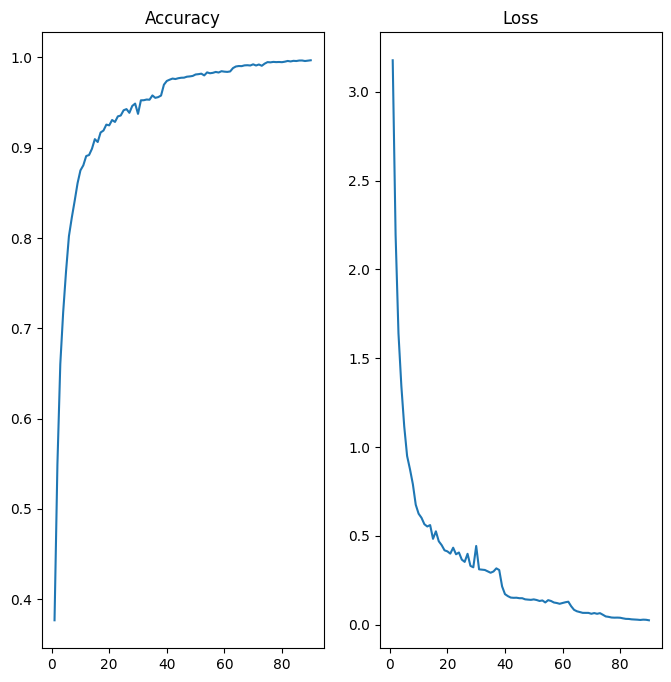

In [16]:
epochs_range = range(1, len(history.history['accuracy']) + 1)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label='Training Accuracy')
# plt.plot(epochs_range,history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label='Training Loss')
# plt.plot(epochs_range,history.history['val_loss'],label='Validation Loss')
plt.title('Loss')
plt.show()

# Submission

In [17]:
import cv2

# Load the test data
X_test = np.load('/kaggle/working/test.npy', allow_pickle=True)
X_test = X_test.astype('float32') / 255

In [18]:
res = model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("reco_nav.csv", index_label="ID")

2024-06-02 01:25:05.972453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 2.30534, expected 1.33474
2024-06-02 01:25:05.972519: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 2.5238, expected 1.5532
2024-06-02 01:25:05.972529: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 2.74464, expected 1.77404
2024-06-02 01:25:05.972537: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 2.90685, expected 1.93625
2024-06-02 01:25:05.972544: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 2.25878, expected 1.28819
2024-06-02 01:25:05.972552: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 2.94579, expected 1.9752
2024-06-02 01:25:05.972560: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 3.12761, expected 2.15701
2024-06-02 01:25:05.972567: E external/local_xla/xla/service/gpu/

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

2024-06-02 01:25:09.591033: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 0: 1.65884, expected 0.662364
2024-06-02 01:25:09.591088: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 1: 2.17118, expected 1.17471
2024-06-02 01:25:09.591098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 2: 2.01663, expected 1.02015
2024-06-02 01:25:09.591106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 3: 2.22297, expected 1.22649
2024-06-02 01:25:09.591113: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 4: 2.01716, expected 1.02069
2024-06-02 01:25:09.591121: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 5: 1.82691, expected 0.830437
2024-06-02 01:25:09.591129: E external/local_xla/xla/service/gpu/buffer_comparator.cc:149] Difference at 6: 2.60073, expected 1.60426
2024-06-02 01:25:09.591137: E external/local_xla/xla/service

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step


In [19]:
!head reco_nav.csv

ID,Category
0,5
1,2
2,2
3,3
4,8
5,8
6,4
7,2
8,7


In [20]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'reco_nav.csv')

/kaggle/working/reco_nav.csv